In [201]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [373]:
words = open('src/names.txt').read().splitlines()

In [374]:
chars = list(sorted(set(''.join(words))))

stoi = {ch:i+1 for i, ch in enumerate(chars) }
itos = {i+1:ch for i, ch in enumerate(stoi)}
itos[0] = '.'
vocab_size = len(itos)

stoi['.']=0

In [375]:
import random
random.seed(42)
random.shuffle(words)

In [376]:

block_size = 8
def build_dataset(words) :
    Xs, Ys = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            Xs.append(context)
            Ys.append(stoi[ch])
            t =  [itos[i] for i in context]
            context = context[1:] + [stoi[ch]]
            
    Xs = torch.tensor(Xs)
    Ys = torch.tensor(Ys)

    return Xs, Ys



In [377]:
n1 = int(0.8 * len(words) )
n2 = int(0.9 * len(words) )

X_tr, Y_tr = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test =  build_dataset(words[n2:])

In [441]:
#PYTORCH ADAPTATION

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim = True)
            xvar = x.var(dim, keepdim = True, unbiased = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:

    def __init__(self, num_embedding, embedding_dim):
        self.weights = torch.rand((num_embedding, embedding_dim))
        
    def __call__(self, ix):
        self.out = self.weights[ix]
        return self.out

    def parameters(self):
        return [self.weights]

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        self.out = x.view(B, -1 , C * self.n).squeeze()
        return self.out

    def parameters(self):
        return []
        

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [442]:
torch.manual_seed(42)

In [477]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


170897


In [478]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
        
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    Xb, Yb = X_tr[ix], Y_tr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01

    for p in parameters:
        p.data += - lr * p.grad

    if i % 10000 == 0:
        print(f'{i} / {max_steps} : {loss.item()}')
    lossi.append(loss.log10().item())
    

0 / 200000 : 4.236364364624023
10000 / 200000 : 1.843356966972351
20000 / 200000 : 1.8026642799377441
30000 / 200000 : 2.0208170413970947
40000 / 200000 : 2.0043745040893555
50000 / 200000 : 2.4265873432159424
60000 / 200000 : 1.87282133102417
70000 / 200000 : 2.0034730434417725
80000 / 200000 : 1.9120335578918457
90000 / 200000 : 1.9571099281311035
100000 / 200000 : 1.6552625894546509
110000 / 200000 : 1.9816550016403198
120000 / 200000 : 1.748762845993042
130000 / 200000 : 1.7368890047073364
140000 / 200000 : 1.9384733438491821
150000 / 200000 : 1.896120548248291
160000 / 200000 : 1.5699182748794556
170000 / 200000 : 1.6170673370361328
180000 / 200000 : 2.042475938796997
190000 / 200000 : 1.9203776121139526


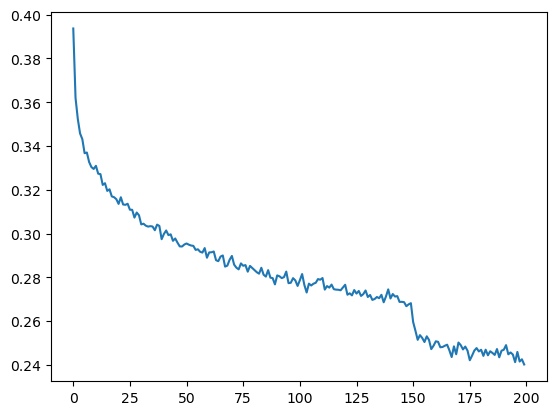

In [479]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [480]:
for layer in model.layers:
    layer.training = False

In [481]:
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (X_tr, Y_tr),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.735775113105774
val 1.9876879453659058


In [482]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

genese.
kemari.
anikit.
pextyn.
octavious.
johnnie.
khartli.
rosslyn.
vihan.
jaedon.
adamie.
nakarii.
rylin.
jemechanner.
blaydon.
yaanvi.
skil.
milaq.
darker.
shimu.
